# Computing uncertainties from the strain rate fits. 

- load data
- compute profiles and velocities, $w$
- extract only $w$ in the region we want to fit
- fit with numpy, scipy, xarray
- examine the cross-correlation matrices we get from them 


In [1]:
%reload_ext autoreload
import sys
sys.path.append("../../../xapres")
import xapres as xa
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit

In [145]:
fd = xa.load.from_dats()
data_directory = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data'
file_names = fd.list_files(data_directory)
len(file_names)


ds = xa.load.generate_xarray(data_directory, computeProfiles=False)
ds = ds.sortby('time').mean('chirp_num')
ds = ds.assign_coords({"time": ds.time- np.timedelta64(3, 'h')})
ds.time.attrs['long_name'] = 'time (PA time: UTC-3hrs)'
ds_c = ds.isel(time = slice(5,-1))
stacked = ds_c.addProfileToDs()
w = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 400, offset = 6)

In [3]:
w

<xarray.Dataset>
Dimensions:                  (shot_number: 2, time: 88,
                              attenuator_setting_pair: 2, profile_range: 39999,
                              bin_depth: 1999)
Coordinates:
    filename                 (shot_number, time) <U23 'DATA2024-12-08-1958.DA...
    folder_name              (time) <U4 'Data' 'Data' 'Data' ... 'Data' 'Data'
    burst_number             (shot_number, time) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    AFGain                   (time, attenuator_setting_pair) int64 -4 ... -14
    attenuator               (time, attenuator_setting_pair) float64 20.0 ......
    orientation              (time) <U7 'unknown' 'unknown' ... 'unknown'
  * profile_range            (profile_range) float64 0.0 0.2103 ... 8.411e+03
    profile_time             (shot_number, time) datetime64[ns] 2024-12-08T16...
  * time                     (time) datetime64[ns] 2024-12-08T19:58:36.500000...
  * shot_number              (shot_number) int64 1 2
  * attenuator_setting_pair  (attenuator_setting_pair) int64 0 1
  * bin_depth                (bin_depth) float64 1.998 6.204 ... 8.405e+03
Data variables:
    profile                  (shot_number, time, attenuator_setting_pair, profile_range) complex128 ...
    coherence                (time, attenuator_setting_pair, bin_depth) complex128 ...
    phase                    (time, attenuator_setting_pair, bin_depth) float64 ...
    phase_uncertainty        (time, attenuator_setting_pair, bin_depth) float64 ...
    displacement             (time, attenuator_setting_pair, bin_depth) float64 ...
    disp_uncertainty         (time, attenuator_setting_pair, bin_depth) float64 ...
    velocity                 (time, attenuator_setting_pair, bin_depth) float64 ...
    velocity_uncertainty     (time, attenuator_setting_pair, bin_depth) float64 ...
    strain_rate              (time, attenuator_setting_pair) float64 0.002314...
    surface_intercept        (time, attenuator_setting_pair) float64 -15.94 ....
    r_squared                (time, attenuator_setting_pair) float64 3.91e-05...
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     20
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       6

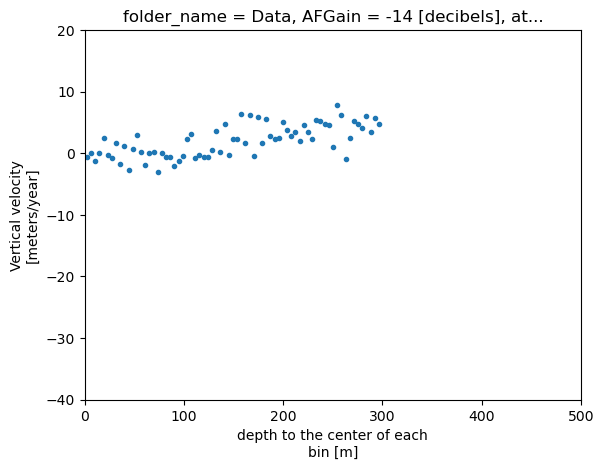

In [146]:
one_w = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0,300))
xdata = one_w.bin_depth.values
ydata = one_w.velocity.values
sigma = one_w.velocity_uncertainty.values
one_w.velocity.plot(xlim=[0,500], ylim=[-40, 20], marker='.', linestyle = 'None')

<ErrorbarContainer object of 3 artists>

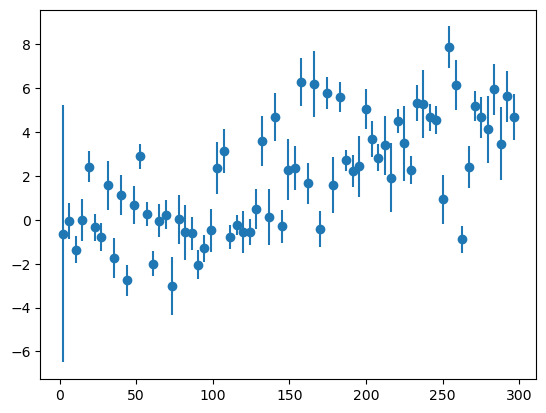

In [35]:
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

In [36]:
def func(x, a, c):
    return a * x + c

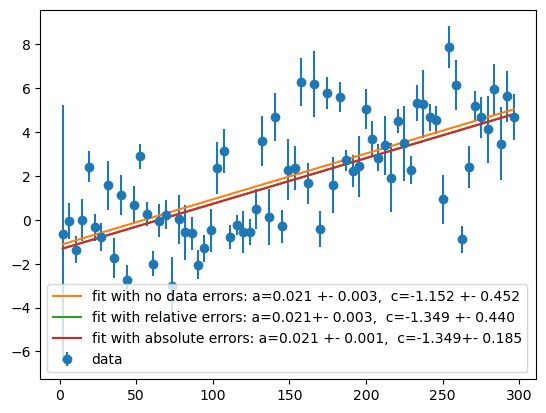

In [37]:
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata)
popt_sigma, pcov_sigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=False)
popt_Abssigma, pcov_Abssigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)


plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

perr = np.sqrt(np.diag(pcov))
plt.plot(xdata, func(xdata, *popt),
         label=f'fit with no data errors: a={popt[0]:5.3f} +- {perr[0]:5.3f},  c={popt[1]:5.3f} +- {perr[1]:5.3f}')

perr = np.sqrt(np.diag(pcov_sigma))
plt.plot(xdata, func(xdata, *popt_sigma),
         label=f'fit with relative errors: a={popt_sigma[0]:5.3f}+- {perr[0]:5.3f},  c={popt_sigma[1]:5.3f} +- {perr[1]:5.3f}')

perr = np.sqrt(np.diag(pcov_Abssigma))
plt.plot(xdata, func(xdata, *popt_Abssigma),
         label=f'fit with absolute errors: a={popt_Abssigma[0]:5.3f} +- {perr[0]:5.3f},  c={popt_Abssigma[1]:5.3f}+- {perr[1]:5.3f}')


plt.legend()

## Numpy's polyfit gives very nearly the same numbers for the coofecients. 

In [ ]:
assert np.allclose(popt_Abssigma, np.polyfit(xdata, ydata, 1, w=1/sigma))
assert np.allclose(popt, np.polyfit(xdata, ydata, 1))

### the uncertainties in the coeffients are also the same

In [ ]:
# in the case when no uncertainties are supplied
p, cov = np.polyfit(xdata, ydata, 1, cov=True)
perr = np.sqrt(np.diag(pcov))
assert np.allclose(np.sqrt(np.diag(cov)), perr)

# in the case when the uncertainties supplied are relative
p, cov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov=True)
perr = np.sqrt(np.diag(pcov_sigma))
assert np.allclose(np.sqrt(np.diag(cov)), perr)

# in the case when the uncertainties supplied are absolute
p, cov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov='unscaled')
perr = np.sqrt(np.diag(pcov_Abssigma))
assert np.allclose(np.sqrt(np.diag(cov)), perr)

## xarray's curvefit gives the same result as scipy's curvefit

In [ ]:
# no errors
xarray_fit = one_w.velocity.polyfit('bin_depth', 1, cov = True)
assert np.allclose(xarray_fit.sel(degree = 1, drop =True).polyfit_coefficients.values, popt[0])
assert np.allclose(xarray_fit.sel(degree = 0, drop =True).polyfit_coefficients.values, popt[1])
perr = np.sqrt(np.diag(pcov))
assert np.allclose(perr, np.sqrt(np.diag(xarray_fit.polyfit_covariance)))

# relative errors
xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = True, w=1/sigma)
assert np.allclose(xarray_fit.sel(degree = 1, drop =True).polyfit_coefficients.values, popt_sigma[0])
assert np.allclose(xarray_fit.sel(degree = 0, drop =True).polyfit_coefficients.values, popt_sigma[1])
perr = np.sqrt(np.diag(pcov_sigma))
assert np.allclose(perr, np.sqrt(np.diag(xarray_fit.squeeze().polyfit_covariance)))

# absolute errors
xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = 'unscaled', w=1/sigma)
assert np.allclose(xarray_fit.sel(degree = 1, drop =True).polyfit_coefficients.values, popt_Abssigma[0])
assert np.allclose(xarray_fit.sel(degree = 0, drop =True).polyfit_coefficients.values, popt_Abssigma[1])
perr = np.sqrt(np.diag(pcov_Abssigma))
assert np.allclose(perr, np.sqrt(np.diag(xarray_fit.squeeze().polyfit_covariance)))

## Now that we are getting the right answers, we will implement it in utils.py

In [212]:
# xdata, ydata, 1, w=1/sigma
import xarray as xr

# Define a slim wrapper around np.polyfit
def my_polyfit(x, y, deg=1, cov='unscaled'):
    # Returns [coeff_deg, ..., coeff_0]
    # e.g. for deg=1 -> [slope, intercept]
    p, cov = np.polyfit(x, y, deg=deg, cov='unscaled')
    perr = np.sqrt(np.diag(cov))
    return p, perr
res = xr.apply_ufunc(
    my_polyfit,
    one_w.bin_depth,
    one_w.velocity,
    input_core_dims=[["bin_depth"], ["bin_depth"]],
    output_core_dims=[["degree"],["degree"]],
    vectorize=True             # needed to apply along multiple slices
)
out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty")]
xr.merge(out)

<xarray.Dataset>
Dimensions:                  (degree: 2)
Coordinates:
    folder_name              <U4 'Data'
    AFGain                   int64 -14
    attenuator               float64 10.0
    orientation              <U7 'unknown'
    time                     datetime64[ns] 2024-12-11T07:01:48
    attenuator_setting_pair  int64 1
Dimensions without coordinates: degree
Data variables:
    parameters               (degree) float64 0.02088 -1.152
    parameter_uncertainty    (degree) float64 0.001377 0.2372

### Next job is to check we are still getting the same values and that it works for an xarray with more dimensions. 